In [1]:
#Importing the neccecary Librarues
import numpy as np  
import pandas as pd 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

import warnings
warnings.simplefilter('ignore')

In [2]:
#Reading the data
df = pd.read_csv('./data/data.csv')
df.head()

,time_id,ping_ms,temperature_c,humidity_p
0,2021-09-30 21:08:02,17.28,25,35
1,2021-09-30 21:09:02,17.73,23,40
2,2021-09-30 21:10:01,18.59,22,41
3,2021-09-30 21:12:02,16.73,22,42
4,2021-09-30 21:13:02,18.12,22,42


In [3]:
#Cleaning the data
df['time_id'] = pd.to_datetime(df['time_id'], format='%Y/%m/%d %H:%M')
df.set_index('time_id',inplace=True)

x = df.values
x_scaled = StandardScaler()
x_scaled = x_scaled.fit_transform(x)
dfNorm = pd.DataFrame(x_scaled, columns=df.columns)

In [4]:
# stationary testing of data

def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace = True)
    return differenced_data 

def test_stationary(data,column='',significance=0.05,series=False):
    if series:
        adf_test = adfuller(data,autolag='AIC')
    else:
        adf_test = adfuller(data[column],autolag='AIC')
    p_value = adf_test[1]
    if p_value <= significance:
        results = "Stationary"
    else:
        results = "Non-Stationary"
    return results

for columns in dfNorm:
    results = test_stationary(dfNorm, columns)
    print(results)
    if results == "Non-Stationary":
        dfNorm[columns] = differencing(dfNorm, columns, 1)

Non-Stationary
Stationary
Stationary


In [5]:
#Calculate Max_Lag using Vector AutoRegressive Model
max_lag = 100
var_model = VAR(df)
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic

#Finding anomalies
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions,threshold

var = VAR(df)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2

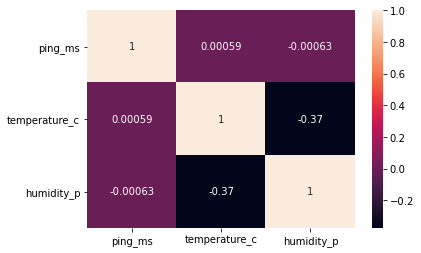

In [6]:
sns.heatmap(dfNorm.corr(), annot=True)

In [7]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions,threshold
var = VAR(df)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2

In [8]:
predictions, threshold = find_anomalies(squared_errors)

In [9]:
data = df.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
predicted = data[data['Predictions']==1].index
data = data.drop(index=predicted)

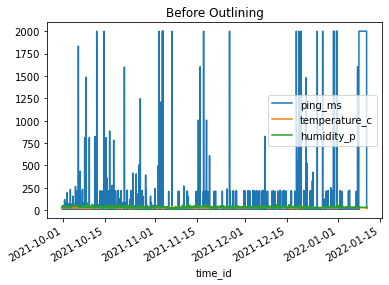

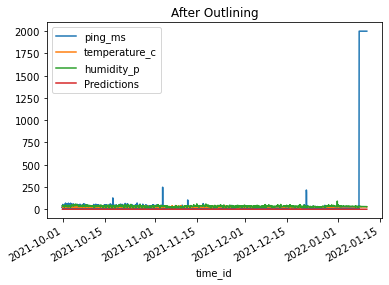

In [10]:
df.plot(title = 'Before Outlining')
data.plot(title = 'After Outlining')
